In [1]:
# Install WandB for experiment tracking
!pip install wandb -q

In [ ]:
import wandb

# Login to WandB (chỉ cần chạy 1 lần đầu tiên)
# Lấy API key tại: https://wandb.ai/authorize
wandb.login(key="")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Multi-Scale CycleGAN: Night to Day Conversion

**Notebook cập nhật tương thích với TensorFlow 2.x / Keras 3.x**

## Các thay đổi chính:
- ✅ Cập nhật imports: `from tensorflow.keras import ...`
- ✅ Fix các vấn đề về shape và type casting
- ✅ Cập nhật API cho optimizers và regularizers
- ✅ Thêm kiểm tra file weights trước khi load
- ✅ Fix discriminator outputs trong GAN model

## Yêu cầu:
```bash
pip install tensorflow opencv-python matplotlib pandas numpy
```

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
import pathlib
import cv2
import string
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.12.0
Keras version: 2.12.0


In [4]:
# Initialize WandB project
wandb.init(
    project="night2day-cyclegan",
    name="multi-scale-cyclegan-35k-epochs",
    config={
        "epochs": 30000,
        "batch_size": 4,
        "learning_rate": 0.0001,
        "weight_decay": 6e-8,
        "image_shape": (256, 256, 3),
        "filter": 16,
        "kernel": 5,
        "architecture": "Multi-Scale CycleGAN",
        "dataset": "BDD100K"
    },
    resume="allow"  # Cho phép resume nếu bị gián đoạn
)

config = wandb.config
print("✅ WandB initialized successfully!")

wandb: Currently logged in as: duchung04st (duchung04st-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.23.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251220_162231-hztr5ifh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run multi-scale-cyclegan-35k-epochs
wandb: ⭐️ View project at https://wandb.ai/duchung04st-hanoi-university-of-science-and-technology/night2day-cyclegan
wandb: 🚀 View run at https://wandb.ai/duchung04st-hanoi-university-of-science-and-technology/night2day-cyclegan/runs/hztr5ifh


✅ WandB initialized successfully!


# WandB Configuration

WandB (Weights & Biases) giúp:
- 📊 Track metrics real-time
- 💾 Auto-backup checkpoints lên cloud
- 🖼️ Visualize generated images
- 🔄 Resume training dễ dàng khi Kaggle timeout
- 📈 So sánh multiple runs

# Introduction
- Converting night into day is one of the most interesting applications in generative models, due to the great difficulty in recreating the scene during the day, especially in cases of extreme darkness, and thus the difficulty lies in imagining the scene during the day when the lighting is very weak.
- The proposed system focuses on using a CycleGan architecture that helps in reconstructing the scene in the daytime.
- The structure of the discriminator has been modified so that it can study the correctness of reshaping an object, only a part of which is visible due to extreme darkness and poor lighting. The discriminator was also designed to be able to recognize objects that are close to and far from the camera, so that it studies the correctness of the process of shaping the scene during the day.
- Through the proposed methodology, the discriminator attempts to study the relationship of the pixel with its neighbors, and whether the pixel's current value with its neighbors is correct or not (using kernel = 5 at each output convolutional layer) which helps in evaluating whether the pixel is correctly positioned with respect to its neighbors or not.
- Thus, in this way we try to overcome the problem of great difficulty in reconstructing the scene in extreme darkness.
- During the process of converting night into day, as long as we are studying images that include images of the road, it is possible that some objects may sometimes be close to the camera and others far from the camera, and all we seek is for each object to be recreated in the images as if it were in the daytime. Therefore, the discerner must recognize the entire object, whether it is close to the camera or far from the camera.

In [5]:
image_shape = (256, 256, 3)
kernel = 5
padding = 'same'
learning_rate = 0.0001
weight_decay = 6e-8
filter = 16
strides = 1
source_input = layers.Input(shape = image_shape, name = 'source')
target_input = layers.Input(shape = image_shape, name = 'target')

In [6]:
def inceptionModule(inputs, filter, kernel, padding, strides, activation, use_norm):
    x = inputs
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides,
                    dilation_rate=1)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups=1)(x)
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides,
                      dilation_rate=1)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups=1)(x)
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides,
                      dilation_rate=1)(x)
    x = layers.Activation(activation)(x)
    if use_norm:
        x = layers.GroupNormalization(groups=1)(x)
    return x

In [7]:
def convolution(inputs, filters, kernel, padding, strides, activation, use_norm):
    x = inputs
    x = inceptionModule(x, filters, kernel, padding, strides, activation, use_norm)
    y = layers.Conv2D(filters, kernel_size=1, padding=padding, strides=strides,
                                     activation=activation)(inputs)
    if use_norm:
        y = layers.GroupNormalization(groups=1)(y)

    x = layers.add([x, y])
    return x

In [8]:
def encoder(inputs, filters, padding, strides, activation, kernel, use_norm):
    conv = convolution(inputs, filters, kernel, padding, strides, activation, use_norm)
    return layers.Conv2D(filters, kernel_size=1, padding=padding, strides=2, activation=activation)(conv), conv

def decoder(inputs, skip, filters, padding, strides, kernel, activation, use_norm):
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, padding=padding,
                              strides=2, activation=activation)(inputs)
    x = layers.add([x, skip])
    x = convolution(x, filters, kernel, padding, strides, activation, use_norm)
    return x

# Generator Architecture

In [9]:
def U_net(inputs, filter, padding, strides, activation, kernel, use_norm, name, weights):
    x = inputs
    conv1, skip1 = encoder(x, filter, padding, strides, activation[0], kernel, use_norm)
    conv2, skip2 = encoder(conv1, filter*2, padding, strides, activation[0], kernel, use_norm)
    conv3, skip3 = encoder(conv2, filter*4, padding, strides, activation[0], kernel, use_norm)
    conv4, skip4 = encoder(conv3, filter*8, padding, strides, activation[0], kernel, use_norm)
    conv5, skip5 = encoder(conv4, filter*16, padding, strides, activation[0], kernel, use_norm)
    x = layers.Flatten()(conv5)
    x = layers.Dense(128, name='latent_space',
                     kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = layers.Dense(int(conv5.shape[1]*conv5.shape[2]*conv5.shape[3]),
                    kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = layers.Reshape((int(conv5.shape[1]), int(conv5.shape[2]), int(conv5.shape[3])))(x)
    dec1 = decoder(x, skip5, filter*16, padding, strides, kernel, activation[1], use_norm)
    dec2 = decoder(dec1, skip4, filter*8, padding, strides, kernel, activation[1], use_norm)
    dec3 = decoder(dec2, skip3, filter*4, padding, strides, kernel, activation[1], use_norm)
    dec4 = decoder(dec3, skip2, filter*2, padding, strides, kernel, activation[1], use_norm)
    dec5 = decoder(dec4, skip1, filter, padding, strides, kernel, activation[1], use_norm)
    dec5 = layers.concatenate([
        dec5,
        layers.GroupNormalization(groups=1)(layers.Conv2DTranspose(filter, kernel_size=kernel, padding='same', strides=16,
                                                           activation=activation[1])(dec1)),
    ])
    output = layers.Conv2DTranspose(3, kernel_size=kernel, padding=padding, strides=1)(dec5)
    output = layers.Activation('sigmoid')(output)
    m = models.Model(inputs=inputs, outputs=output, name=name)
    if weights:
        # if name == 'xTOy':
        #     if os.path.exists('/kaggle/working/g_target.h5'):
        #         m.load_weights('/kaggle/working/g_target.h5')
        # elif name == 'yTOx':
        #     if os.path.exists('/kaggle/working/g_source.h5'):
        #         m.load_weights('/kaggle/working/g_source.h5')
        if name == 'xTOy':
            if os.path.exists('/kaggle/working/g_target.h5'):
                m.load_weights('/kaggle/working/g_target.h5')
        elif name == 'yTOx':
            if os.path.exists('/kaggle/working/g_source.h5'):
                m.load_weights('/kaggle/working/g_source.h5')
    return m

# Discriminator Architecture

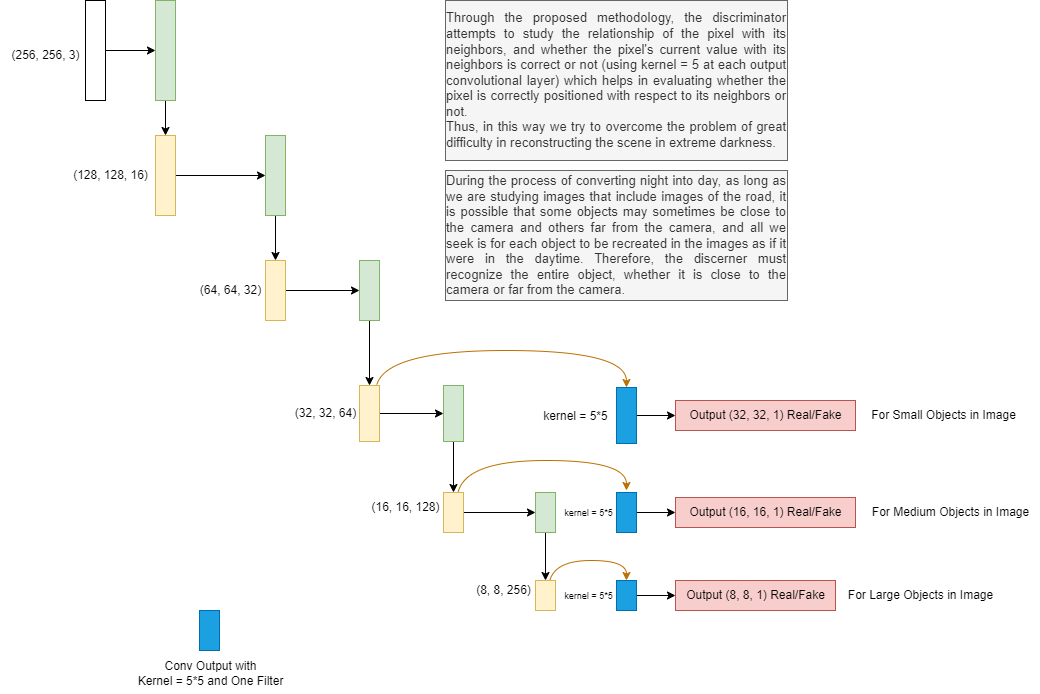

In [10]:
def Discriminator(inputs, filter, padding, strides, kernel, activation, use_norm, name, weights):
    x = inputs
    conv1, skip1 = encoder(x, filter, padding, strides, activation, kernel, use_norm)
    conv2, skip2 = encoder(conv1, filter*2, padding, strides, activation, kernel, use_norm)
    conv3, skip3 = encoder(conv2, filter*4, padding, strides, activation, kernel, use_norm)
    conv4, skip4 = encoder(conv3, filter*8, padding, strides, activation, kernel, use_norm)
    conv5, skip5 = encoder(conv4, filter*16, padding, strides, activation, kernel, use_norm)
    output = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv5)
    output1 = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv4)
    output2 = layers.Conv2D(1, kernel_size=kernel, padding=padding, strides=1)(conv3)
    m = models.Model(inputs=inputs, outputs=[output, output1, output2], name=name)
    if weights:
        if name == 'xx':
            if os.path.exists('/kaggle/working/d_source.h5'):
                m.load_weights('/kaggle/working/d_source.h5')
        elif name == 'yy':
            if os.path.exists('/kaggle/working/d_target.h5'):
                m.load_weights('/kaggle/working/d_target.h5')
    return m

In [11]:
g_target = U_net(source_input, filter, padding, strides, ['LeakyReLU', 'relu'], kernel, 
                 use_norm=True, name='xTOy', weights=False)  # Set to False for first run
g_source = U_net(target_input, filter, padding, strides, ['LeakyReLU', 'relu'], kernel, 
                 use_norm=True, name='yTOx', weights=False)  # Set to False for first run

In [12]:
# discriminator source
d_source = Discriminator(source_input, filter, 'same', 1, kernel, 'LeakyReLU', 
                        use_norm=False, name='xx', weights=False)  # Set to False for first run
# discriminator target
d_target = Discriminator(target_input, filter, 'same', 1, kernel, 'LeakyReLU', 
                        use_norm=False, name='yy', weights=False)  # Set to False for first run

d_source.compile(loss=['mse', 'mse', 'mse'],
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
d_target.compile(loss=['mse', 'mse', 'mse'],
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

d_source.trainable = False
d_target.trainable = False

# forward cyclegan
recon_target_forward = g_target(source_input)
d_target_re = d_target(recon_target_forward)
recon_source_forward = g_source(recon_target_forward)

# backward cyclegan
recon_source_backward = g_source(target_input)
d_source_re = d_source(recon_source_backward)
recon_target_backward = g_target(recon_source_backward)

# for identity
iden_target = g_target(target_input)
iden_source = g_source(source_input)

gan = models.Model(inputs=[source_input, target_input],
                  outputs=[d_target_re[0], d_target_re[1], d_target_re[2],
                          d_source_re[0], d_source_re[1], d_source_re[2],
                          recon_source_forward,
                          recon_target_backward,
                          iden_source,
                          iden_target],
                  name='generative_gan')

loss_weights = [1, 1, 1, 1, 1, 1, 10, 10, 0.5, 0.5]
losses = ['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mae', 'mae', 'mae', 'mae']

gan.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate*0.5),
           loss_weights=loss_weights)

In [13]:
gan.output

[<KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'yy')>,
 <KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'yy')>,
 <KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'yy')>,
 <KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'xx')>,
 <KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'xx')>,
 <KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'xx')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'yTOx')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'xTOy')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'yTOx')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'xTOy')>]

In [14]:
gan.summary()

Model: "generative_gan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 xTOy (Functional)              (None, 256, 256, 3)  19274323    ['source[0][0]',                 
                                                                  'yTOx[1][0]',      

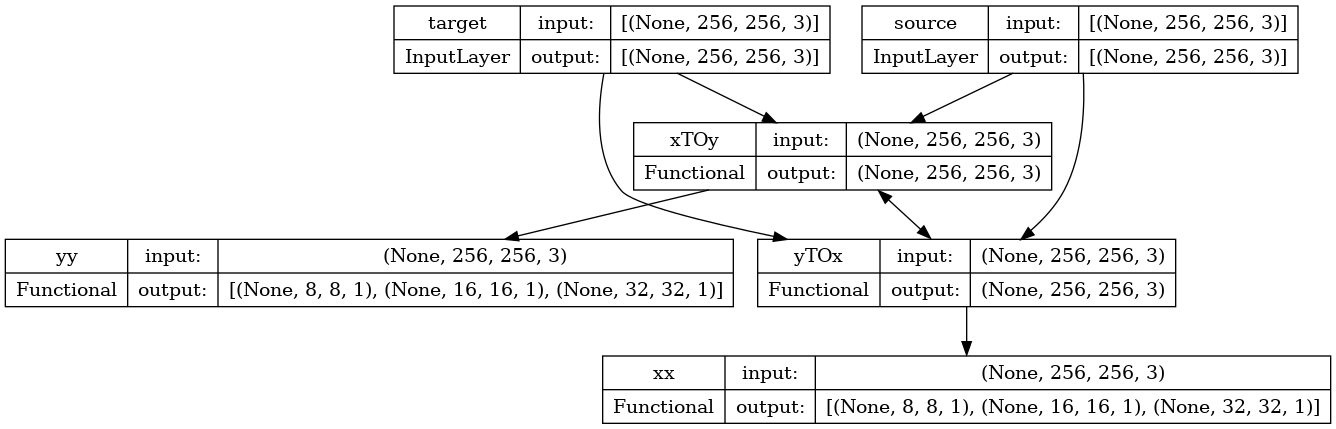

In [15]:
tf.keras.utils.plot_model(gan, show_shapes = True)

In [16]:
def read_images(pathes):
    images = []
    for img in pathes:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = img/255
        images.append(img)
    return np.array(images)

In [17]:
source_pathes = np.array(sorted(list(pathlib.Path('/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainA').glob('*.*'))))
target_pathes = np.array(sorted(list(pathlib.Path('/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainB').glob('*.*'))))

In [18]:
def samples(G, start):
    images = G.predict(start, verbose = 0)
    allImages = np.vstack([start, images])
    plt.figure(figsize = (6, 3))
    for i in range(8):
        plt.subplot(2, 4, (i + 1))
        plt.imshow(allImages[i])
    plt.show()

In [19]:
def save_weight(g_target, g_source, d_source, d_target, epoch):
    """Lưu weights local và upload lên WandB cloud"""
    
    # Tạo thư mục checkpoint
    checkpoint_dir = f'/kaggle/working/checkpoint_epoch_{epoch}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Lưu weights
    g_target_path = f'{checkpoint_dir}/g_target.h5'
    g_source_path = f'{checkpoint_dir}/g_source.h5'
    d_source_path = f'{checkpoint_dir}/d_source.h5'
    d_target_path = f'{checkpoint_dir}/d_target.h5'
    
    g_target.save_weights(g_target_path)
    g_source.save_weights(g_source_path)
    d_source.save_weights(d_source_path)
    d_target.save_weights(d_target_path)
    
    # Lưu weights vào thư mục working (để backward compatibility)
    g_target.save_weights('/kaggle/working/g_target.h5')
    g_source.save_weights('/kaggle/working/g_source.h5')
    d_source.save_weights('/kaggle/working/d_source.h5')
    d_target.save_weights('/kaggle/working/d_target.h5')
    
    # Upload lên WandB Cloud (tự động backup)
    artifact = wandb.Artifact(
        name=f'cyclegan-checkpoint',
        type='model',
        description=f'CycleGAN checkpoint at epoch {epoch}'
    )
    
    artifact.add_file(g_target_path, name='g_target.h5')
    artifact.add_file(g_source_path, name='g_source.h5')
    artifact.add_file(d_source_path, name='d_source.h5')
    artifact.add_file(d_target_path, name='d_target.h5')
    
    # Lưu epoch number
    epoch_file = f'{checkpoint_dir}/epoch.txt'
    with open(epoch_file, 'w') as f:
        f.write(str(epoch))
    artifact.add_file(epoch_file, name='epoch.txt')
    
    wandb.log_artifact(artifact)
    
    print(f"✅ Saved and uploaded checkpoint at epoch {epoch}")

In [20]:
def getPatchGan(shape_):
    return np.vstack([np.ones(shape=shape_),
                      np.zeros(shape=shape_)])

def ones(shape_):
    return np.ones(shape=shape_)

In [21]:
def load_checkpoint_from_wandb():
    """Load checkpoint từ WandB hoặc từ Kaggle input nếu có"""
    
    # Thử load từ WandB trước
    try:
        api = wandb.Api()
        artifact = api.artifact('night2day-cyclegan/cyclegan-checkpoint:latest')
        artifact_dir = artifact.download()
        
        # Đọc epoch number
        with open(f'{artifact_dir}/epoch.txt', 'r') as f:
            start_epoch = int(f.read())
        
        print(f"📂 Found WandB checkpoint at epoch {start_epoch}")
        print(f"📥 Downloaded to: {artifact_dir}")
        
        return artifact_dir, start_epoch
    except Exception as e:
        print(f"⚠️ WandB checkpoint not found: {e}")
        
        # Nếu không có trên WandB, thử load từ Kaggle input
        kaggle_checkpoint_dir = '/kaggle/input/test/tensorflow2/default/1'
        if os.path.exists(f'{kaggle_checkpoint_dir}/g_target.h5'):
            print(f"📂 Found local checkpoint in {kaggle_checkpoint_dir}")
            
            # Đọc epoch nếu có file epoch.txt, nếu không thì mặc định 32000
            epoch_file = f'{kaggle_checkpoint_dir}/epoch.txt'
            if os.path.exists(epoch_file):
                with open(epoch_file, 'r') as f:
                    start_epoch = int(f.read())
            else:
                start_epoch = 32000  # Epoch mặc định nếu không có file
            
            print(f"🔄 Will resume from epoch {start_epoch}")
            return kaggle_checkpoint_dir, start_epoch
        else:
            print("⚠️ No checkpoint found, starting from scratch")
            return None, 0

# Training CycleGAN

> **I have trained CycleGan For 20000 Epochs**

In [22]:
epochs = 30000
batch_size = 4
patchGan1 = (batch_size, 8, 8, 1)
patchGan2 = (batch_size, 16, 16, 1)
patchGan3 = (batch_size, 32, 32, 1)

# Số lượng images có sẵn
num_images = min(len(source_pathes), len(target_pathes))
print(f"📊 Dataset size: {num_images} images")
print(f"🎯 Target epochs: {epochs}")

# Resume từ checkpoint nếu có
start_epoch = 0
checkpoint_dir, start_epoch = load_checkpoint_from_wandb()

if checkpoint_dir is not None:
    print(f"🔄 Loading weights from epoch {start_epoch}...")
    g_target.load_weights(f'{checkpoint_dir}/g_target.h5')
    g_source.load_weights(f'{checkpoint_dir}/g_source.h5')
    d_source.load_weights(f'{checkpoint_dir}/d_source.h5')
    d_target.load_weights(f'{checkpoint_dir}/d_target.h5')
    print("✅ Weights loaded successfully!")

print(f"🚀 Starting training from epoch {start_epoch}")

for i in range(start_epoch, epochs):
    indexs = np.random.randint(num_images, size=(batch_size,))
    source_images = read_images(source_pathes[indexs])
    target_images = read_images(target_pathes[indexs])
    
    real_source = source_images
    real_target = target_images
    fake_source = g_source.predict(real_target, verbose=0)
    fake_target = g_target.predict(real_source, verbose=0)
    
    allImagesSource = np.vstack([real_source, fake_source])
    allImagesTarget = np.vstack([real_target, fake_target])
    
    # Train discriminators
    all_d_source, d1, d2, d3 = d_source.train_on_batch(allImagesSource, [
        getPatchGan(patchGan1),
        getPatchGan(patchGan2),
        getPatchGan(patchGan3)])
    
    all_d_target, dt1, dt2, dt3 = d_target.train_on_batch(allImagesTarget, [
        getPatchGan(patchGan1),
        getPatchGan(patchGan2),
        getPatchGan(patchGan3)])
    
    # Train GAN
    gan_result = gan.train_on_batch([real_source, real_target], [
        ones(patchGan1),   # d_target_re[0]
        ones(patchGan2),   # d_target_re[1]
        ones(patchGan3),   # d_target_re[2]
        ones(patchGan1),   # d_source_re[0]
        ones(patchGan2),   # d_source_re[1]
        ones(patchGan3),   # d_source_re[2]
        real_source,       # recon_source_forward (cycle consistency)
        real_target,       # recon_target_backward (cycle consistency)
        real_source,       # iden_source (identity)
        real_target        # iden_target (identity)
    ])
    
    # Unpack results
    all_loss = gan_result[0]
    loss_1_1, loss_1_2, loss_1_3 = gan_result[1], gan_result[2], gan_result[3]
    loss_2_1, loss_2_2, loss_2_3 = gan_result[4], gan_result[5], gan_result[6]
    loss_3, loss_4 = gan_result[7], gan_result[8]
    loss_5, loss_6 = gan_result[9], gan_result[10]
    
    # Calculate average losses
    g_source_loss_avg = (loss_1_1 + loss_1_2 + loss_1_3) / 3
    g_target_loss_avg = (loss_2_1 + loss_2_2 + loss_2_3) / 3
    
    # 📊 Log metrics lên WandB mỗi step
    wandb.log({
        "epoch": i,
        "discriminator/d_source_loss": float(all_d_source),
        "discriminator/d_target_loss": float(all_d_target),
        "discriminator/d_source_scale1": float(d1),
        "discriminator/d_source_scale2": float(d2),
        "discriminator/d_source_scale3": float(d3),
        "discriminator/d_target_scale1": float(dt1),
        "discriminator/d_target_scale2": float(dt2),
        "discriminator/d_target_scale3": float(dt3),
        "generator/g_source_loss": float(g_source_loss_avg),
        "generator/g_target_loss": float(g_target_loss_avg),
        "generator/g_source_scale1": float(loss_1_1),
        "generator/g_source_scale2": float(loss_1_2),
        "generator/g_source_scale3": float(loss_1_3),
        "generator/g_target_scale1": float(loss_2_1),
        "generator/g_target_scale2": float(loss_2_2),
        "generator/g_target_scale3": float(loss_2_3),
        "cycle/source_loss": float(loss_3),
        "cycle/target_loss": float(loss_4),
        "identity/source_loss": float(loss_5),
        "identity/target_loss": float(loss_6),
        "total/gan_loss": float(all_loss)
    })
    
    # 💾 Lưu checkpoint mỗi 2000 epochs
    if i % 2000 == 0 and i > 0:
        save_weight(g_target, g_source, d_source, d_target, i)
    
    # 🖼️ Log hình ảnh và print progress mỗi 1000 epochs
    if i % 1000 == 0:
        print(f'\n📍 Epoch: {i}/{epochs}')
        
        # Generate samples
        fake_day = g_target.predict(source_images[:4], verbose=0)
        fake_night = g_source.predict(target_images[:4], verbose=0)
        
        # Log images lên WandB
        wandb.log({
            "samples/generated_day": [wandb.Image(img, caption=f"Night→Day") for img in fake_day],
            "samples/generated_night": [wandb.Image(img, caption=f"Day→Night") for img in fake_night],
            "samples/real_night": [wandb.Image(img, caption="Real Night") for img in source_images[:4]],
            "samples/real_day": [wandb.Image(img, caption="Real Day") for img in target_images[:4]],
            "comparison/night_to_day": wandb.Image(
                np.hstack([source_images[0], fake_day[0]]),
                caption="Night (left) → Day (right)"
            ),
            "comparison/day_to_night": wandb.Image(
                np.hstack([target_images[0], fake_night[0]]),
                caption="Day (left) → Night (right)"
            )
        })
        
        # Console logging
        str_ = f'source_discr: {all_d_source:.4f}, target_discr: {all_d_target:.4f}'
        str_2 = f'source_gener: {g_source_loss_avg:.4f}, target_gener: {g_target_loss_avg:.4f}'
        str_3 = f'recon_target: {loss_3:.4f}, recon_source: {loss_4:.4f}'
        str_4 = f'ident_target: {loss_5:.4f}, ident_source: {loss_6:.4f}'
        print(str_ + ' | ' + str_2)
        print(str_3 + ' | ' + str_4)
        print('Source to Target Samples')
        samples(g_target, source_images)
        print('Target to Source Samples')
        samples(g_source, target_images)

# 🎉 Kết thúc training
print("\n🎉 Training completed!")
save_weight(g_target, g_source, d_source, d_target, epochs-1)
wandb.finish()

📊 Dataset size: 24750 images
🎯 Target epochs: 30000


wandb: Downloading large artifact cyclegan-checkpoint:latest, 190.62MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:2.6


📂 Found WandB checkpoint at epoch 32000
📥 Downloaded to: ./artifacts/cyclegan-checkpoint:v15
🔄 Loading weights from epoch 32000...
✅ Weights loaded successfully!
🚀 Starting training from epoch 32000

🎉 Training completed!


wandb: Waiting for W&B process to finish... (success).


✅ Saved and uploaded checkpoint at epoch 29999


wandb: 🚀 View run multi-scale-cyclegan-35k-epochs at: https://wandb.ai/duchung04st-hanoi-university-of-science-and-technology/night2day-cyclegan/runs/hztr5ifh
wandb: Synced 6 W&B file(s), 0 media file(s), 5 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251220_162231-hztr5ifh/logs


# 📊 Xem kết quả training

Sau khi chạy training, bạn có thể:

1. **Xem dashboard trực tiếp**: https://wandb.ai/your-username/night2day-cyclegan
   - Real-time loss curves
   - Generated images qua từng epoch
   - System metrics (GPU, RAM, etc.)

2. **Download checkpoints**: 
   - Vào tab "Artifacts" trong project
   - Chọn checkpoint muốn tải về
   - Click "Download"

3. **Resume training**:
   - Nếu Kaggle session timeout, chỉ cần chạy lại notebook
   - WandB tự động detect và resume từ checkpoint gần nhất

4. **So sánh runs**:
   - Chạy multiple experiments với config khác nhau
   - WandB tự động track và compare

In [23]:
def draw_compare(road_ligh,
                 road_night, type_):
  plt.figure(figsize = (12, 13))
  index = 0
  n = 0
  for i in range(16):
    plt.subplot(4, 4, (i + 1))
    if index == 0:
      plt.imshow(road_night[n])
      plt.title(type_[0])
      index = 1
    elif index == 1:
      plt.imshow(road_ligh[n])
      plt.title(type_[1])
      index = 0
      n = n + 1
  plt.legend()

# Results

In [24]:
def generator_samples(pathes_, m, type_):
  indexs = np.random.randint(15000, size = (8,))
  images = read_images(pathes_[indexs])
  draw_compare(np.squeeze(m.predict(images, verbose = 0)), images, type_)

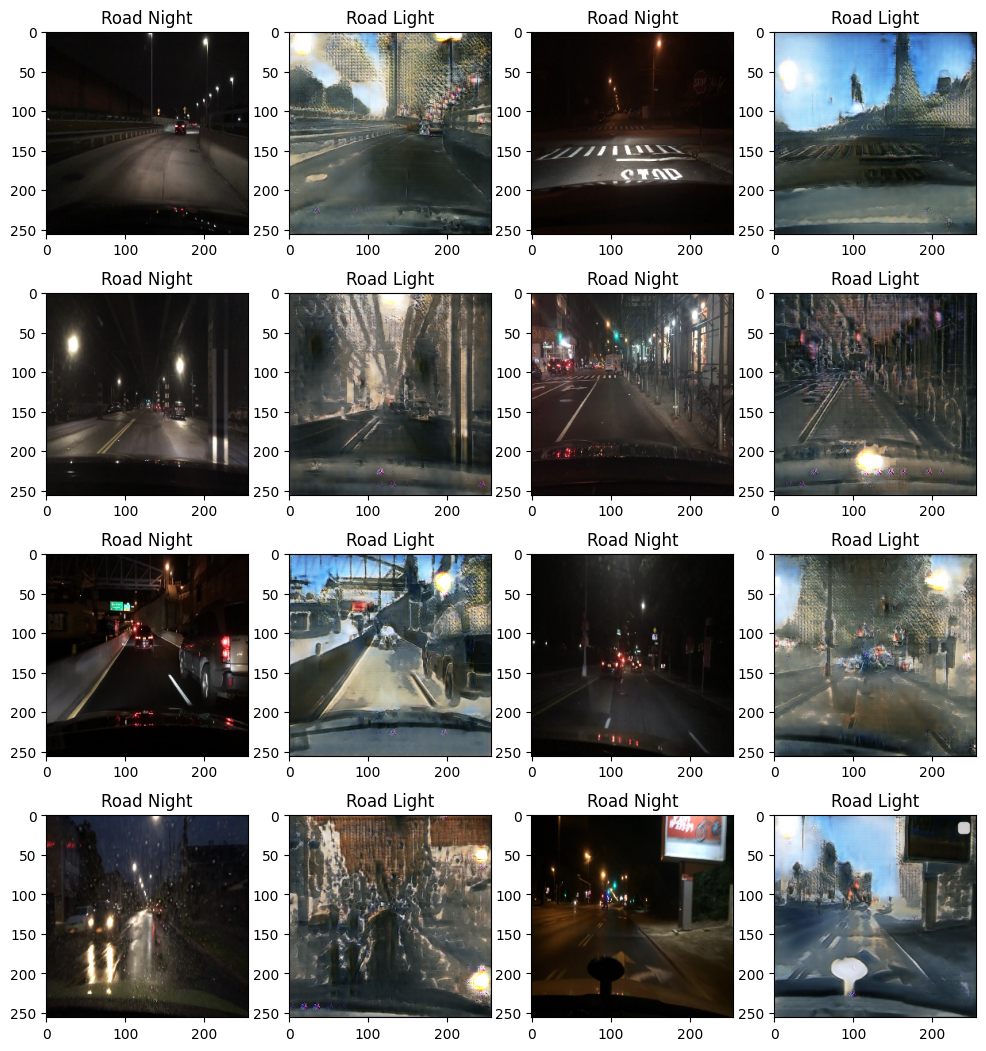

In [25]:
generator_samples(target_pathes, g_source, ['Road Night', 'Road Light'])

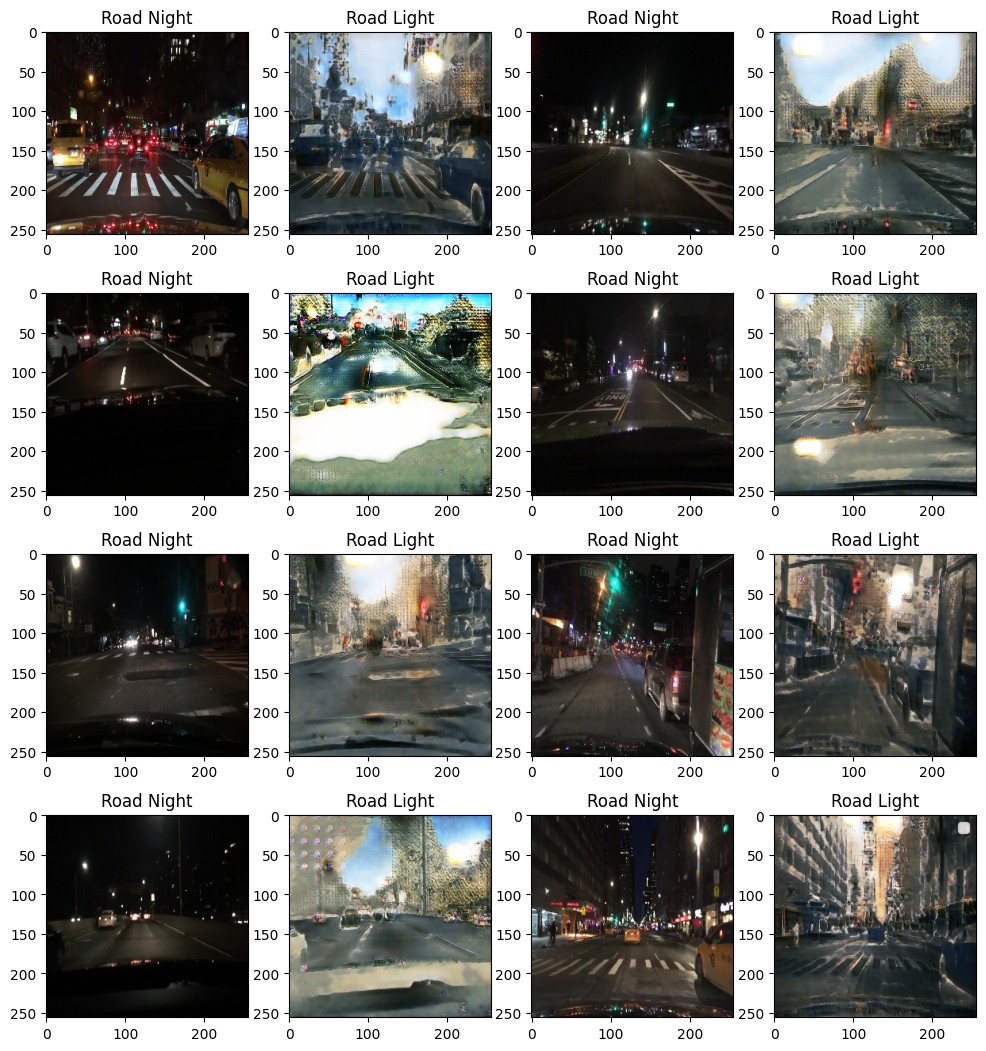

In [26]:
generator_samples(target_pathes, g_source, ['Road Night', 'Road Light'])

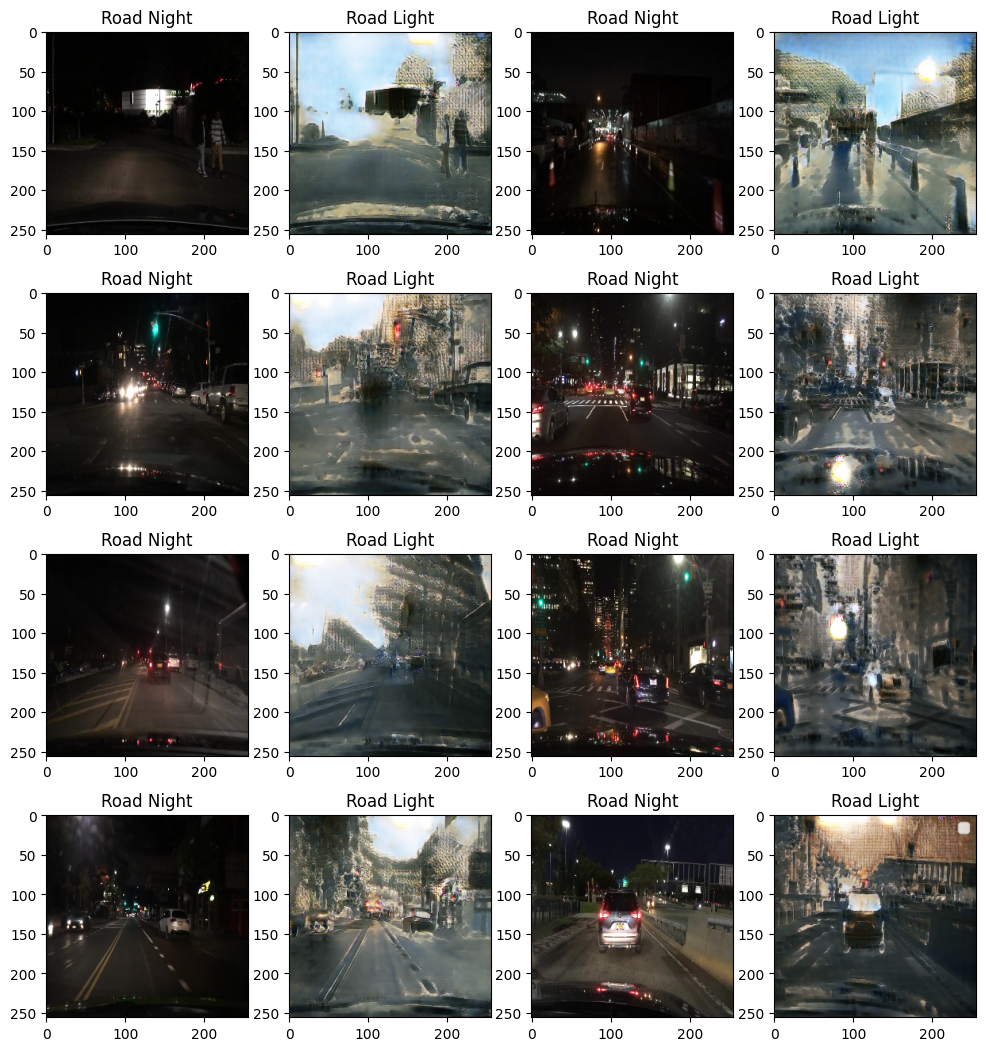

In [27]:
generator_samples(target_pathes, g_source, ['Road Night', 'Road Light'])